In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
import numpy as np
import os
import seaborn as sns

import gzip
import pickle

os.chdir('../')
from functions.model_wrapper import Tree_Model, rfm_params, xgboost_params

In [2]:
from functions.dataprep import group_values, replace_DateTime_CycleTime, strong_low_pass_filter, plot_Current, strong_low_pass_filter
from functions.model_wrapper import get_y_w_threshold

# Obtain paths of all data files

In [3]:
data_dir = 'data/raw_data/'
data_files = [file for file in os.listdir(data_dir) if 'Meta' not in file 
              and 'sdu' not in file 
              and 'jena' not in file
              and 'png' not in file
              and 'pckl' not in file
             and '.DS_Store' not in file
             and 'CH' in file]


# Focus on four features:
## 1. Charge Capacity
## 2. Temperature
## 3. Internal Resistance
## 4. DateTime (time the measurement was made)
      We convert this to the difference between the start of the current and the start of previous cycle.  


In [8]:
columns = ["Charge_Capacity", "Temperature", "Internal_Resistance", "DateTime"][:]
hows = ["max", "mean", "max", "min"][:]
data_frames = []  
for i, column in enumerate(columns[::]):
    df_col =  pd.DataFrame()
    print(column)
    for data_file in data_files:
        df_file = pd.DataFrame()  
        df_file = pd.read_csv(f'../Nature_battery/data/raw_data/{data_file}')
        df_file = df_file[df_file['Cycle_Index'] >= 2]
        # plot_CV(df_file)
        df_col = pd.concat([df_col, group_values(df_file.loc[1:,:], column, hows[i], data_file[:-4])], axis = 1)  # discard first row (first cycle)
    data_frames.append(df_col)


Charge_Capacity
Temperature
Internal_Resistance
DateTime


# Plot raw data

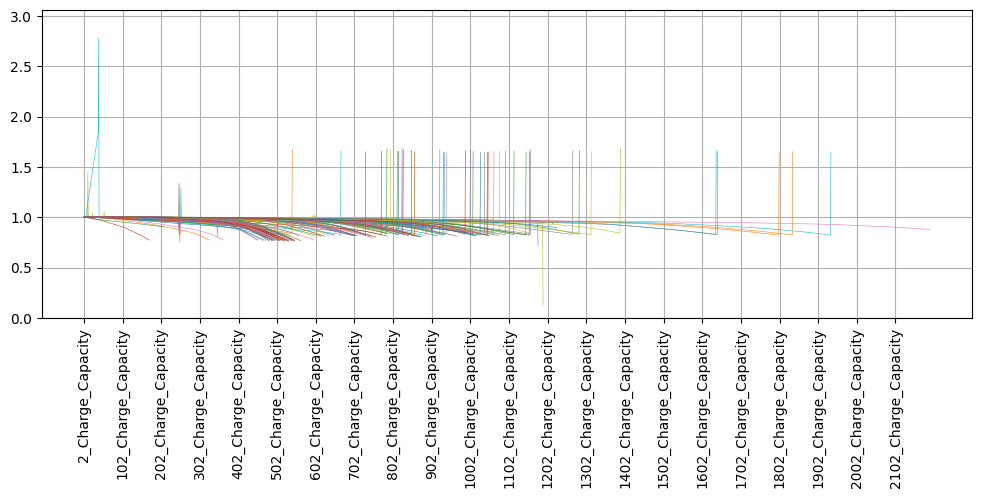

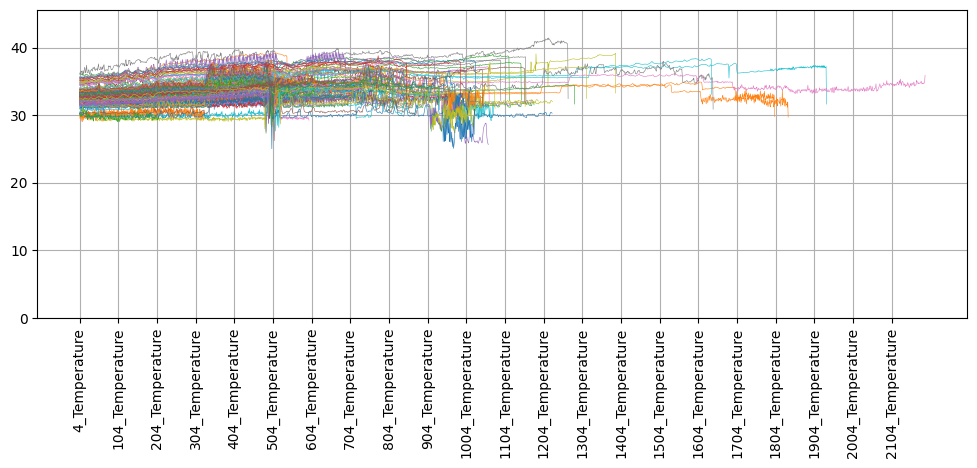

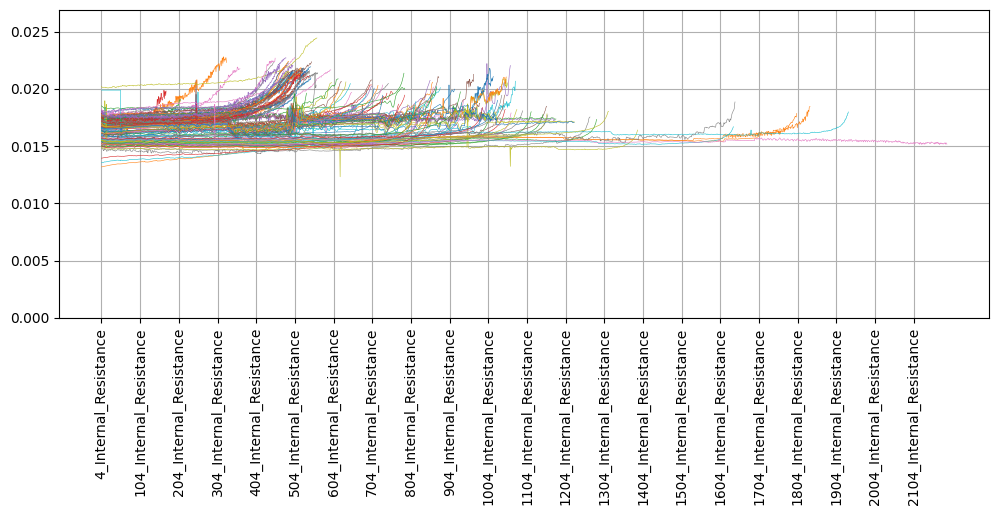

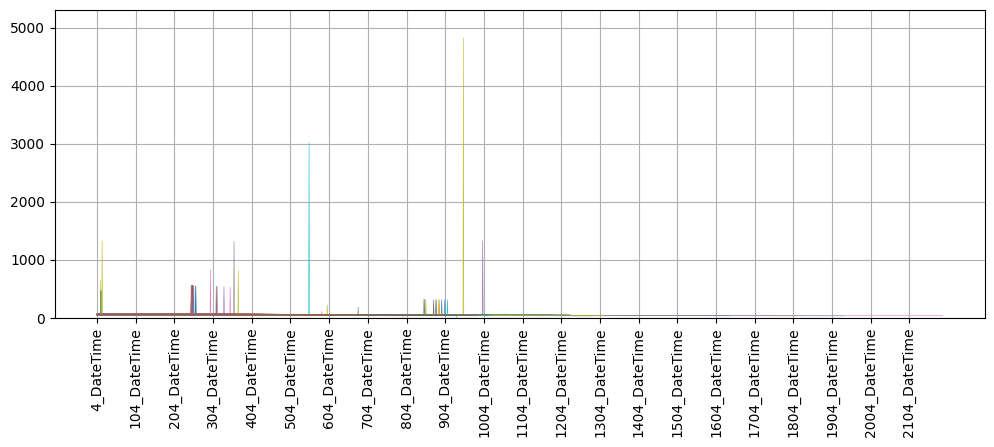

In [9]:
for i in range(4):
    plt.figure(figsize = (12,4))
    plt.plot(data_frames[i], linewidth = 0.4)
    plt.xticks(np.arange(0,data_frames[i].shape[0]+10,100), rotation = 90)
    y_max = data_frames[i].max().max()
    y_min = data_frames[i].min().min()
    plt.ylim(y_min - y_min/np.abs(y_min)*(np.abs(y_min)*0.1), 
             y_max*1.1)
    plt.ylim(y_max*0.0, y_max*1.1)
    plt.grid()
    plt.show()

# Below replaces any reference of "DateTime" to "CycleTime" since the former also means of format of time, so it is confusing and needs to be replaced.

In [10]:
data_frames = replace_DateTime_CycleTime(data_frames)

# Obtain the schedule version information.  There are two groups of samples.  
## 7.00.08 has longer cycle time.
## 7.00.13 has shorter cycle time.

In [11]:
schedule_versions = []
indices = []
for data_file in data_files:
    data_file_prefix = data_file.split('.')[0]
    indices.append(data_file_prefix)
    meta_data_file = data_file_prefix + '_Metadata.csv'
    schedule_versions.append(pd.read_csv(data_dir+meta_data_file)["schedule_version"].values[0][-7:])
df_schedule_version = pd.DataFrame(data = schedule_versions,
                                   columns = ['schedule_version'],
                                   index= indices
                                   ).T
df_schedule_version

2017-06-30_4_4C-55per_6C_CH19 2018-04-12_batch8_CH38  \
schedule_version                       7.00.08                7.00.13   

                 2018-04-12_batch8_CH10 2017-05-12_7C-30per_3_6C_CH39  \
schedule_version                7.00.13                       7.00.08   

                 2017-06-30_3_6C-80per_3_6C_CH1  \
schedule_version                        7.00.08   

                 2017-06-30_4_4C-47per_5_5C_CH18 2018-04-12_batch8_CH11  \
schedule_version                         7.00.08                7.00.13   

                 2018-04-12_batch8_CH39 2017-05-12_8C-35per_3_6C_CH48  \
schedule_version                7.00.13                       7.00.08   

                 2017-06-30_4_8C-80per_4_8C_CH4  ... 2018-04-12_batch8_CH34  \
schedule_version                        7.00.08  ...                7.00.13   

                 2017-06-30_5_2C-66per_3_5C_CH35 2018-04-12_batch8_CH1  \
schedule_version                         7.00.08               7.00.13   

                 2018-04-12_batch8_CH20 2017-05-12_6C-40per_3C_CH25  \
schedule_version                7.00.13                     7.00.08   

                 2017-05-12_7C-40per_3_6C_CH41 2018-04-12_batch8_CH21  \
schedule_version                       7.00.08                7.00.13   

                 2018-04-12_batch8_CH35 2017-06-30_4_8C-80per_4_8C_CH8  \
schedule_version                7.00.13                        7.00.08   

                 2017-05-12_6C-40per_3_6C_CH34  
schedule_version                       7.00.08  

[1 rows x 136 columns]

In [12]:
data_frames.append(df_schedule_version)

In [13]:
with gzip.open('data/data_frames.pckl', 'wb') as f:
    pickle.dump(data_frames, f)

In [5]:
with gzip.open('data/data_frames.pckl', 'rb') as f:
    data_frames = pickle.load(f)

# Calculate the predicted variable y_all which is the number of cycles for the Charge Capacity to drop to 90% of full.

In [15]:
# get y which is number of cycle it dropped below threshold
threshold = 0.9
y_all = get_y_w_threshold(data_frames[0], threshold)

# Apply a strong low pass filter to each data set.

In [16]:
filtered_data_frames = []
for data_frame in data_frames:
    if data_frame.shape[0] > 1:
        filtered_data_frames.append(strong_low_pass_filter(data_frame.copy(), filter_value = 0.01))
    else:
        filtered_data_frames.append(data_frame)

Processing Charge_Capacity
Processing Temperature
Processing Internal_Resistance
Processing CycleTime


# Plot filtered data set

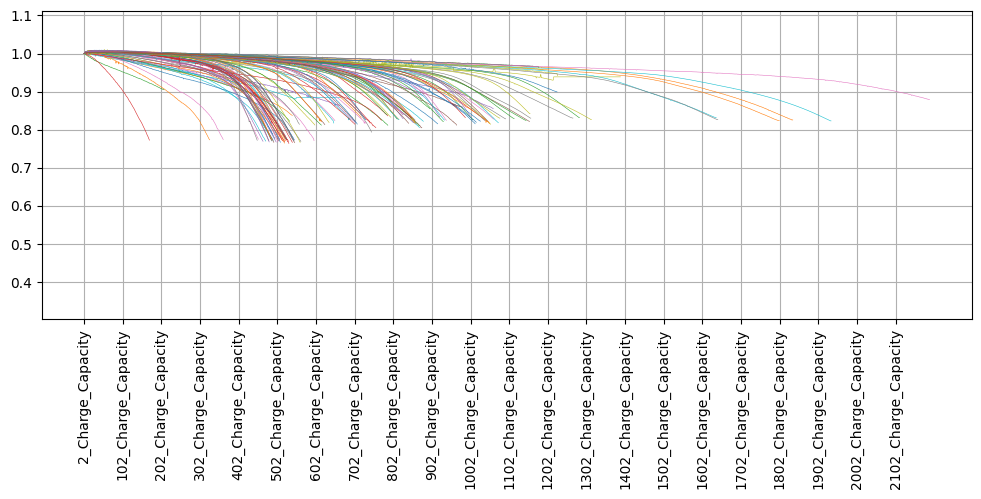

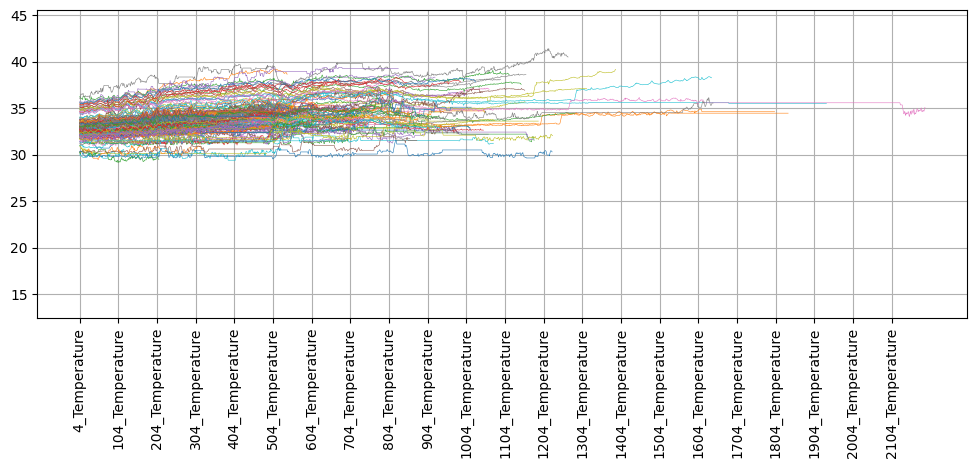

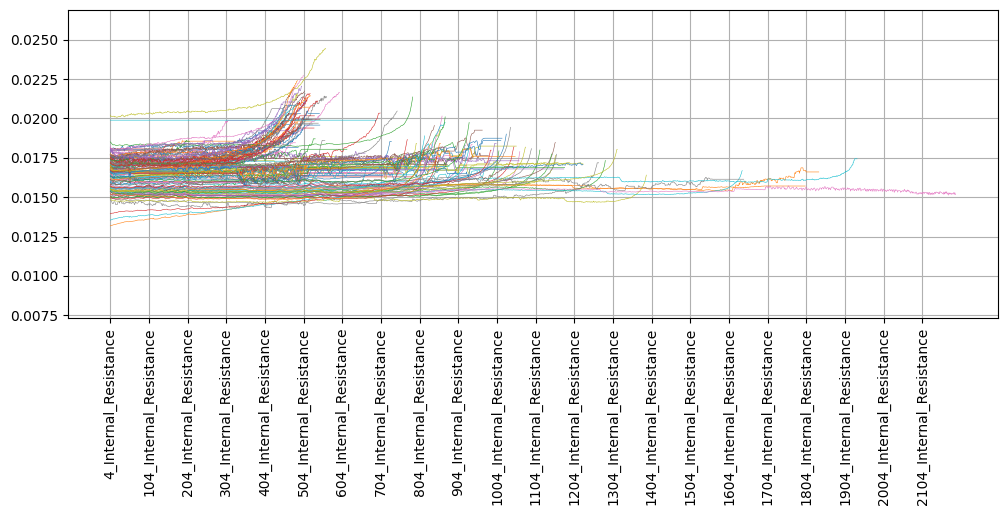

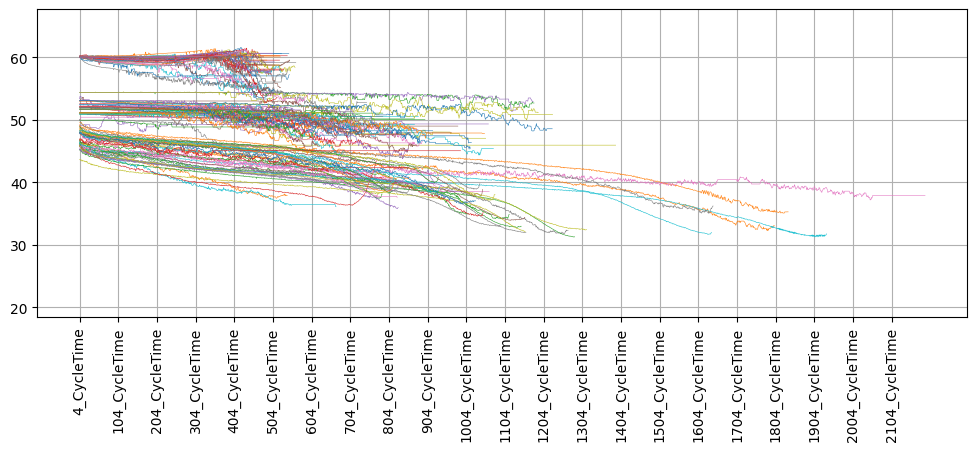

In [17]:
for i in range(4):
    plt.figure(figsize = (12,4))
    plt.plot(filtered_data_frames[i], linewidth = 0.4)
    plt.xticks(np.arange(0, filtered_data_frames[i].shape[0]+10,100), rotation = 90)
    y_max = filtered_data_frames[i].max().max()
    y_min = filtered_data_frames[i].min().min()
    plt.ylim(y_max*0.3, y_max*1.1)
    plt.grid()
    plt.show()

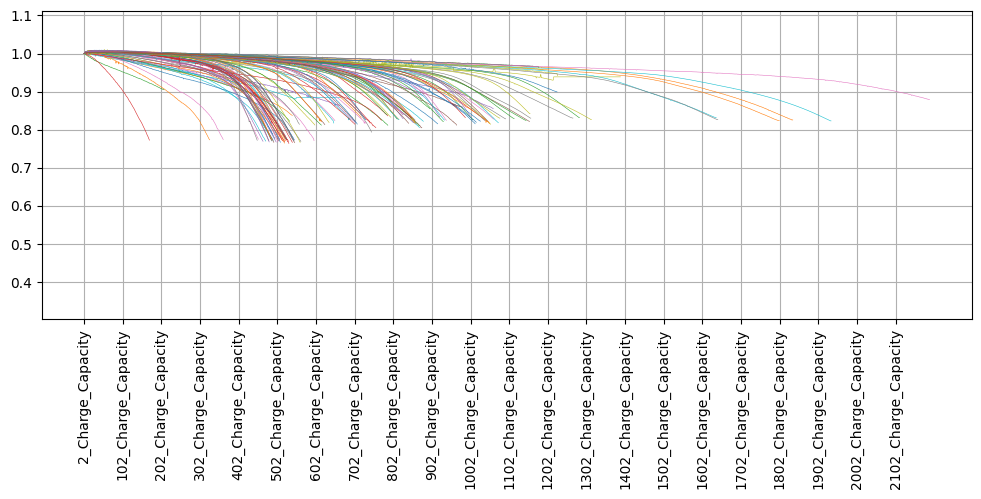

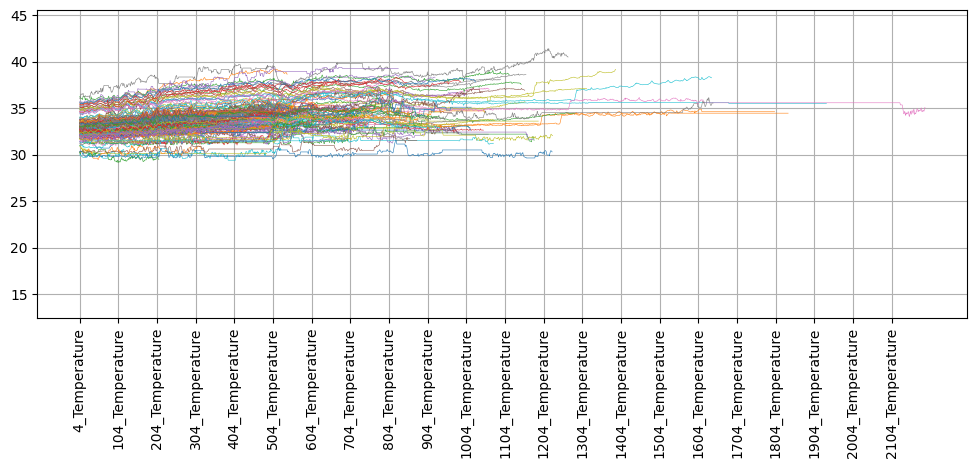

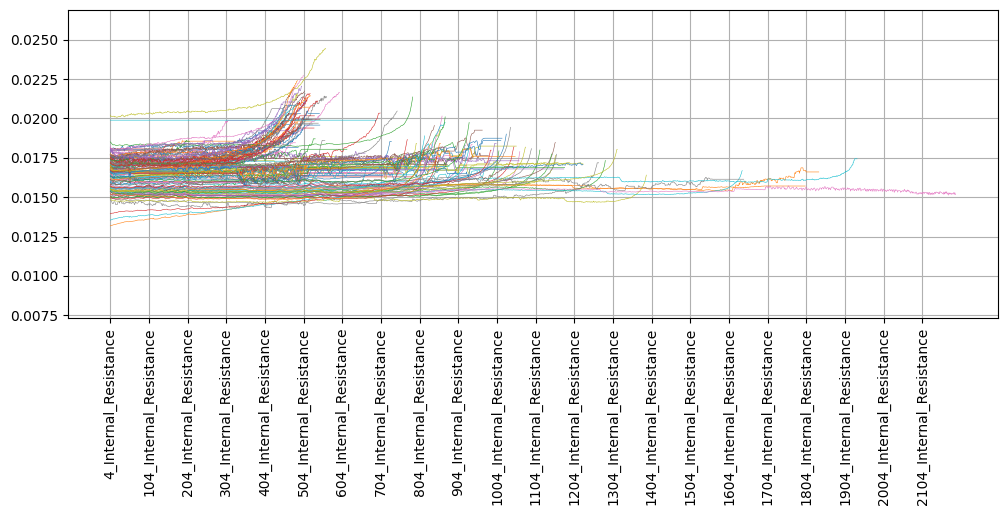

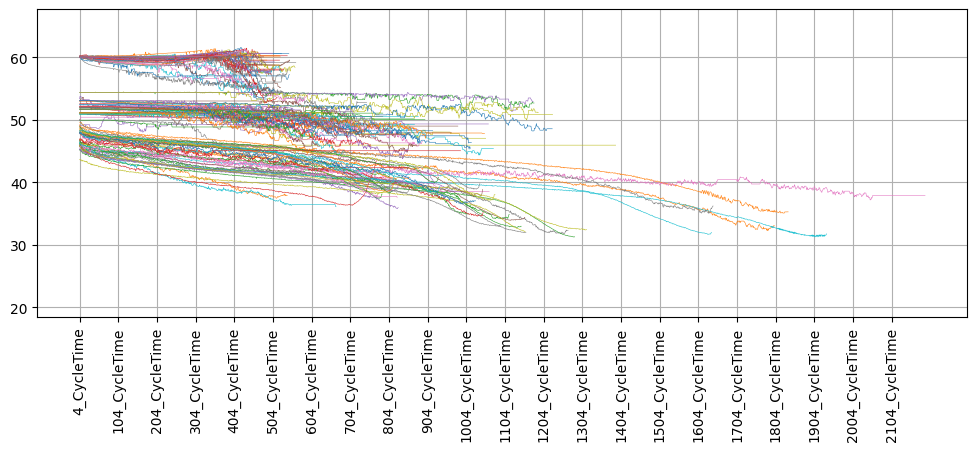

In [18]:
for i in range(4):
    plt.figure(figsize = (12,4))
    plt.plot(filtered_data_frames[i], linewidth = 0.4)
    plt.xticks(np.arange(0, filtered_data_frames[i].shape[0]+10,100), rotation = 90)
    y_max = filtered_data_frames[i].max().max()
    y_min = filtered_data_frames[i].min().min()
    plt.ylim(y_max*0.3, y_max*1.1)
    plt.grid()
    plt.show()

# Compare raw (red) and filtered (blue) data sets

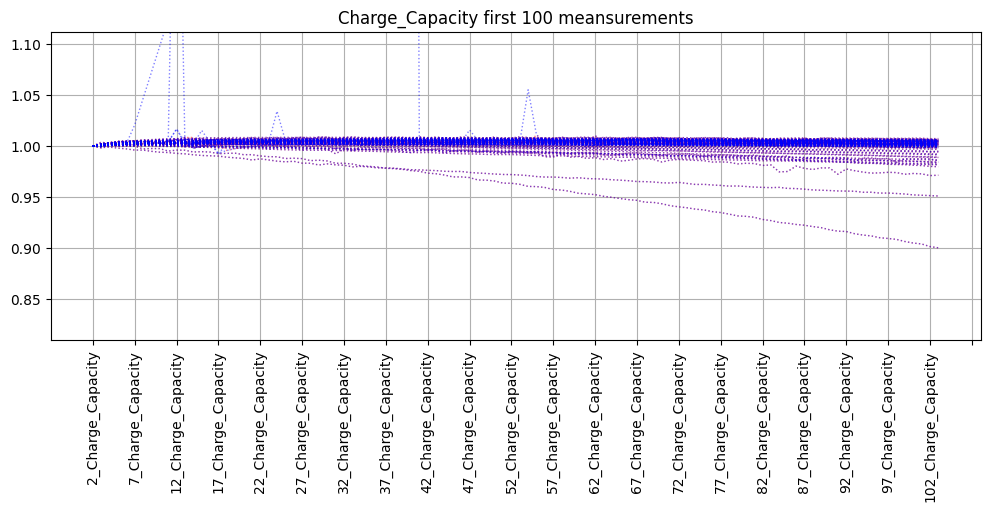

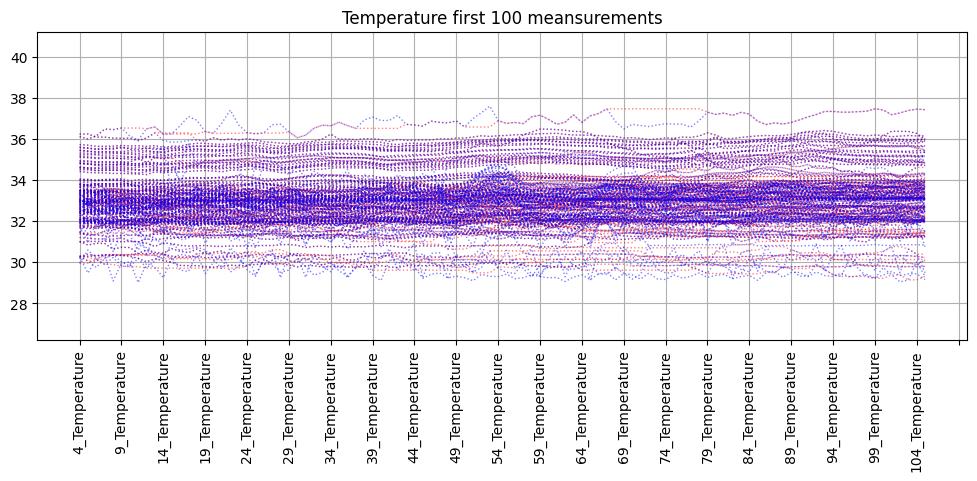

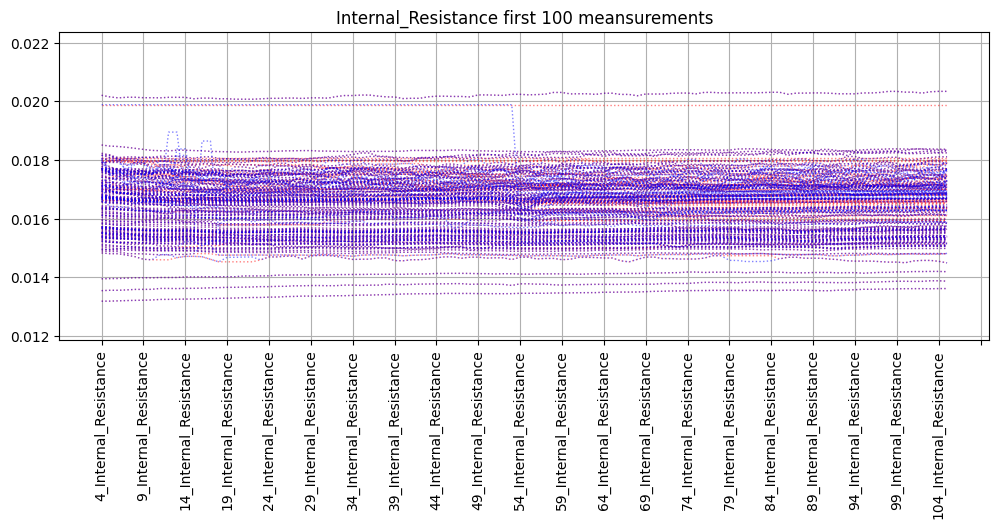

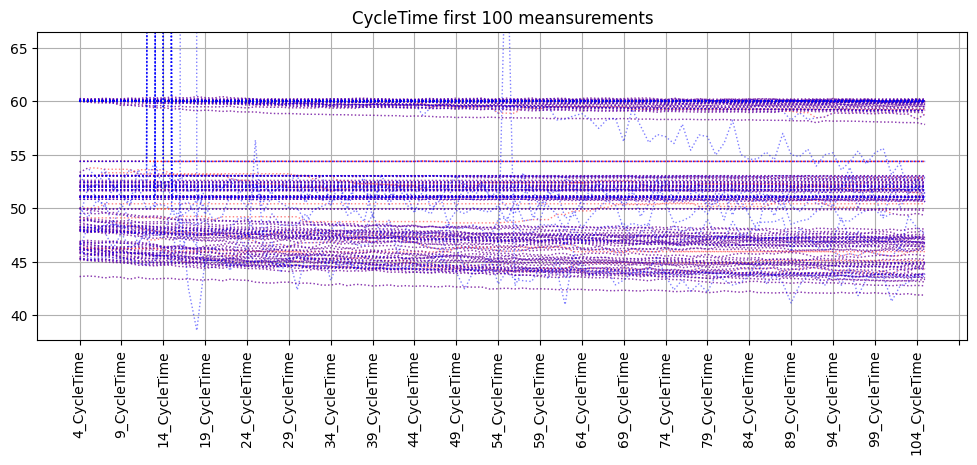

In [19]:
for i in range(4):
    plt.figure(figsize = (12,4))
    plt.title("_".join(filtered_data_frames[i].index[0].split('_')[1:]) + ' first 100 meansurements')
    plt.plot(filtered_data_frames[i].iloc[:102,:], linewidth = 1, linestyle = 'dotted', color = 'r', alpha = 0.5)
    plt.plot(data_frames[i].iloc[:102,:], linewidth = 1, linestyle = 'dotted', color = 'b', alpha = 0.5)
    plt.xticks(np.arange(0, filtered_data_frames[i].iloc[:102,:].shape[0]+5, 5), rotation = 90)
    y_max = filtered_data_frames[i].iloc[:102,:].max().max()
    y_min = filtered_data_frames[i].iloc[:102,:].min().min()
    plt.ylim(y_min - y_min/np.abs(y_min)*(np.abs(y_min)*0.1), 
             y_max*1.1)
    plt.grid()
    # plt.ylim(y_max*0.1, y_max*1.2)
    plt.show()

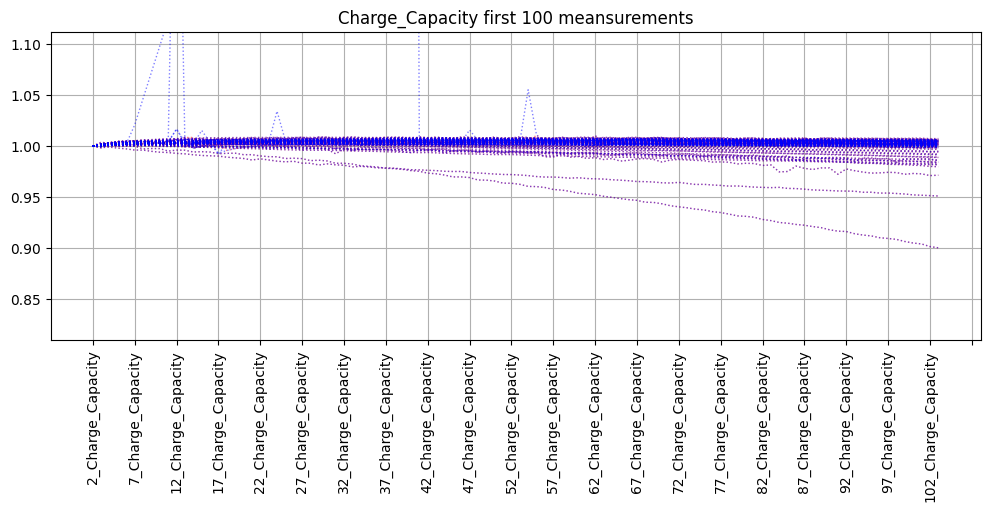

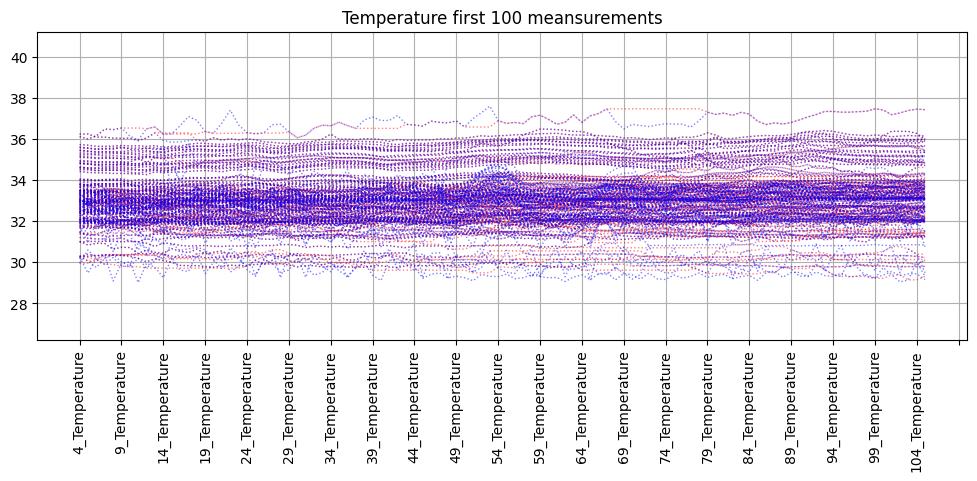

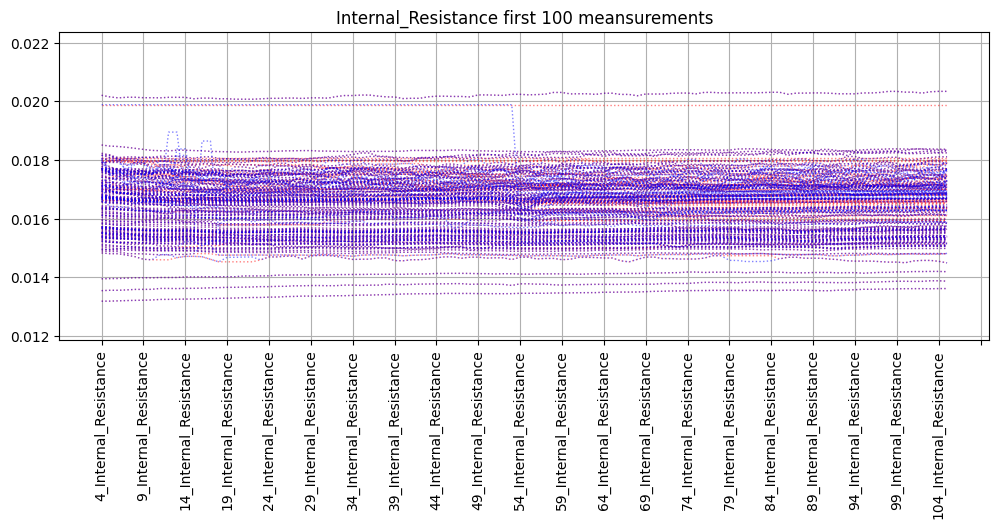

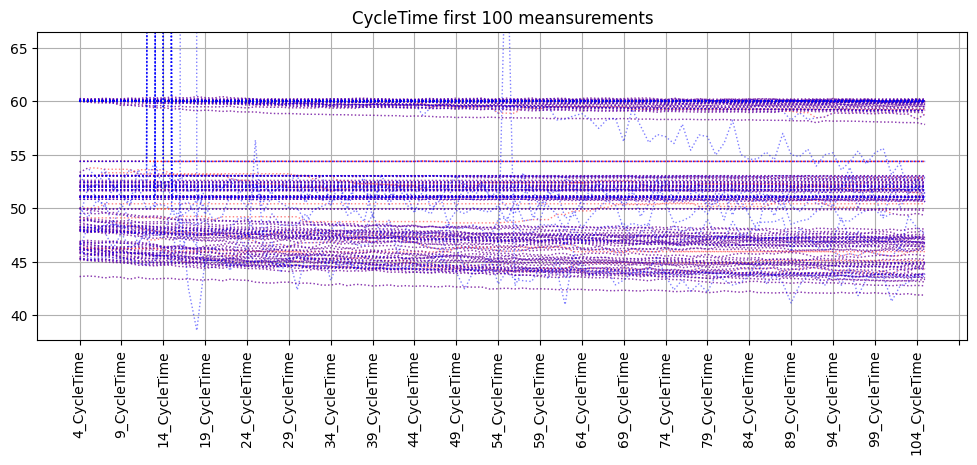

In [20]:
for i in range(4):
    plt.figure(figsize = (12,4))
    plt.title("_".join(filtered_data_frames[i].index[0].split('_')[1:]) + ' first 100 meansurements')
    plt.plot(filtered_data_frames[i].iloc[:102,:], linewidth = 1, linestyle = 'dotted', color = 'r', alpha = 0.5)
    plt.plot(data_frames[i].iloc[:102,:], linewidth = 1, linestyle = 'dotted', color = 'b', alpha = 0.5)
    plt.xticks(np.arange(0, filtered_data_frames[i].iloc[:102,:].shape[0]+5, 5), rotation = 90)
    y_max = filtered_data_frames[i].iloc[:102,:].max().max()
    y_min = filtered_data_frames[i].iloc[:102,:].min().min()
    plt.ylim(y_min - y_min/np.abs(y_min)*(np.abs(y_min)*0.1), 
             y_max*1.1)
    plt.grid()
    # plt.ylim(y_max*0.1, y_max*1.2)
    plt.show()

In [21]:
with gzip.open('data/filtered_data_frames.pckl', 'wb') as f:
    pickle.dump(filtered_data_frames, f)